# Setup and Imports

In [80]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import tqdm

In [81]:
# #!/bin/bash
# !kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection -p ../data

In [82]:
# !unzip ../data/brain-mri-images-for-brain-tumor-detection.zip -d ../data/brain-mri-images-for-brain-tumor-detection

# Helper Functions

In [83]:
def resize_image(image, size=(64, 64)):
    """Resize image for manageable computation."""
    return cv2.resize(image, size)

def mse(image1, image2):
    """Compute Mean Squared Error between two images."""
    return np.mean((image1.astype(float) - image2.astype(float)) ** 2)

def psnr(image1, image2):
    """Compute Peak Signal-to-Noise Ratio."""
    mse_val = mse(image1, image2)
    if mse_val == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 10 * math.log10((PIXEL_MAX ** 2) / mse_val)

def compute_magnitude_spectrum(F):
    """Compute magnitude spectrum using log transformation."""
    return np.log(1 + np.abs(F))

def compute_power_spectrum(F):
    """Compute power spectrum."""
    return np.abs(F) ** 2

# Implementation Based Functions

### Manual DFT and IDFT Functions

In [84]:
def dft2d(image):
    """
    Compute the 2D Discrete Fourier Transform (DFT) manually.
    image: 2D numpy array (grayscale).
    """
    M, N = image.shape
    F = np.zeros((M, N), dtype=complex)
    
    total_iterations = M * N * M * N  # Total iterations for the nested loops
    progress_bar = tqdm.notebook.tqdm(total=total_iterations, desc=">> Computing 2D DFT", unit="steps")

    for u in range(M):
        
        for v in range(N):
            sum_val = 0.0 + 0.0j
            
            for x in range(M):
            
                for y in range(N):
                    angle = -2 * math.pi * ((u * x / M) + (v * y / N))
                    sum_val += image[x, y] * complex(math.cos(angle), math.sin(angle))
                    progress_bar.update(1)  # Update progress bar for each iteration
            
            F[u, v] = sum_val

    progress_bar.close()
    
    return F

def idft2d(F):
    """
    Compute the 2D Inverse Discrete Fourier Transform (IDFT) manually.
    Returns the real part of the reconstructed image.
    """
    M, N = F.shape
    image_recon = np.zeros((M, N), dtype=complex)
    
    total_iterations = M * N * M * N
    progress_bar = tqdm.notebook.tqdm(total=total_iterations, desc=">> Computing 2D IDFT", unit="steps")

    for x in range(M):
        
        for y in range(N):
            sum_val = 0.0 + 0.0j
            
            for u in range(M):
            
                for v in range(N):
                    angle = 2 * math.pi * ((u * x / M) + (v * y / N))
                    sum_val += F[u, v] * complex(math.cos(angle), math.sin(angle))
                    progress_bar.update(1)  # Update progress bar for each iteration
        
            image_recon[x, y] = sum_val / (M * N)
    
    progress_bar.close()
    
    return image_recon.real  # Extract only the real part

### Frequency Domain Filter Generators

In [85]:
def ideal_low_pass_filter(shape, cutoff):
    """Generate an Ideal Low-Pass Filter (ILPF)."""
    M, N = shape
    H = np.zeros((M, N))
    center_u, center_v = M / 2, N / 2
    
    for u in range(M):
    
        for v in range(N):
            distance = math.sqrt((u - center_u) ** 2 + (v - center_v) ** 2)
            H[u, v] = 1 if distance <= cutoff else 0
    
    return H

def butterworth_low_pass_filter(shape, cutoff, order):
    """Generate a Butterworth Low-Pass Filter (BLPF)."""
    M, N = shape
    H = np.zeros((M, N))
    center_u, center_v = M / 2, N / 2
    
    for u in range(M):
    
        for v in range(N):
            distance = math.sqrt((u - center_u) ** 2 + (v - center_v) ** 2)
            H[u, v] = 1 / (1 + (distance / cutoff) ** (2 * order))
    
    return H

def gaussian_low_pass_filter(shape, cutoff):
    """Generate a Gaussian Low-Pass Filter (GLPF)."""
    M, N = shape
    H = np.zeros((M, N))
    center_u, center_v = M / 2, N / 2
    
    for u in range(M):
    
        for v in range(N):
            distance = math.sqrt((u - center_u) ** 2 + (v - center_v) ** 2)
            H[u, v] = math.exp(-(distance ** 2) / (2 * (cutoff ** 2)))
    
    return H

def high_frequency_emphasis_filter(H_lpf, A, B):
    """
    Compute High-Frequency Emphasis Filter.
    Hhp is approximated as (1 - H_lpf).
    """
    H_hp = 1 - H_lpf
    H_hfe = A + B * H_hp
    
    return H_hfe

### Homomorphic Filtering

In [86]:
def homomorphic_filter(image, cutoff, R_h=2.0, R_l=0.5, c=1):
    """
    Apply homomorphic filtering for contrast enhancement.
    Steps:
      - Log transform the image.
      - Compute DFT of the log image.
      - Create a high-pass filter of the form:
          H(u,v) = (R_h - R_l)[1 - exp(-c*(D(u,v)^2/cutoff^2))] + R_l
      - Filter the frequency domain.
      - Compute IDFT, exponentiate, and normalize.
    """
    image = image.astype(float)
    image_log = np.log1p(image)  # log(1+I) to avoid log(0)
    F = dft2d(image_log)
    
    M, N = image.shape
    H = np.zeros((M, N))
    center_u, center_v = M / 2, N / 2
    
    for u in range(M):
        
        for v in range(N):
            D = math.sqrt((u - center_u) ** 2 + (v - center_v) ** 2)
            H[u, v] = (R_h - R_l) * (1 - math.exp(-c * (D ** 2) / (cutoff ** 2))) + R_l
            
    F_filtered = F * H
    image_filtered_log = idft2d(F_filtered)
    image_homomorphic = np.expm1(image_filtered_log)
    
    # Normalizing to 8-bit range [0,255]
    image_homomorphic = np.clip(image_homomorphic, 0, 255)
    image_homomorphic = (image_homomorphic / image_homomorphic.max() * 255).astype(np.uint8)
    
    return image_homomorphic

### Ringing Artifacts: Synthetic Image and Custom Filter

In [87]:
def generate_synthetic_image(size=256, square_size=50):
    """Generate a synthetic image: a white square on a black background."""
    image = np.zeros((size, size), dtype=np.uint8)
    start = (size - square_size) // 2
    end = start + square_size
    image[start:end, start:end] = 255
    
    return image

def custom_filter(shape, cutoff):
    """
    Generate a custom smooth transition filter to reduce ringing artifacts.
    Here we use a modified Gaussian filter.
    """
    M, N = shape
    H = np.zeros((M, N))
    center_u, center_v = M / 2, N / 2
    
    for u in range(M):
    
        for v in range(N):
            D = math.sqrt((u - center_u) ** 2 + (v - center_v) ** 2)
            H[u, v] = math.exp(-(D ** 2) / (2 * (cutoff ** 2 + 1e-5)))
    
    return H

### Question-wise Implementations

In [88]:
def q1_dft_idft():
    """
    Q1: Load a grayscale MRI image from the 'no' folder,
    compute its DFT and manually reconstruct it using IDFT.
    Also compute the MSE and display the original and reconstructed images.
    """
    print("> Loading image")
    img_path = '../data/brain-mri-images-for-brain-tumor-detection/no/1 no.jpeg'
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found. Check the dataset path.")
    img = resize_image(img, size=(64, 64))
    
    print("> Computing DFT and IDFT")
    F = dft2d(img)
    img_recon = idft2d(F)
    
    # Normalizing reconstructed image to 8-bit range
    img_recon_norm = np.clip(img_recon, 0, 255)
    img_recon_norm = (img_recon_norm / img_recon_norm.max() * 255).astype(np.uint8)
    
    print("> Computing MSE")
    error = mse(img, img_recon_norm)
    print(">> Q1 - MSE between original and reconstructed image:", error)
    
    # Display side-by-side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image (No Tumor)")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_recon_norm, cmap='gray')
    plt.title("Reconstructed Image (IDFT)")
    plt.axis('off')
    plt.show()
    
    return img, F, img_recon_norm

def q2_spectrum_analysis(F, img_shape):
    """
    Q2: Compute and visualize the magnitude and power spectrum of the image.
    F: Frequency domain representation from DFT.
    img_shape: shape of the image.
    """
    print("> Computing and displaying magnitude and power spectrum")
    magnitude_spectrum = compute_magnitude_spectrum(F)
    power_spectrum = compute_power_spectrum(F)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title("Magnitude Spectrum")
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.log(1 + power_spectrum), cmap='gray')
    plt.title("Power Spectrum")
    plt.colorbar()
    plt.axis('off')
    plt.show()

def q3_low_pass_filtering(img, F):
    """
    Q3: Apply Ideal, Butterworth, and Gaussian Low-Pass Filters.
    Multiply each filter with the DFT, perform IDFT to reconstruct,
    and display comparisons.
    """
    shape = img.shape
    cutoff = 20  # adjusting cutoff frequency as needed
    order = 2    # Butterworth order
    
    print("> Generating Filters")
    H_ideal = ideal_low_pass_filter(shape, cutoff)
    H_butterworth = butterworth_low_pass_filter(shape, cutoff, order)
    H_gaussian = gaussian_low_pass_filter(shape, cutoff)
    
    print("> Applying Filters and Reconstructing")
    filters = {
        "Ideal LPF": H_ideal,
        "Butterworth LPF": H_butterworth,
        "Gaussian LPF": H_gaussian
    }
    
    reconstructions = {}

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    
    count = 2

    for name, H in filters.items():
        F_filtered = F * H
        img_filt = idft2d(F_filtered)
        img_filt = np.clip(img_filt, 0, 255)
        img_filt = (img_filt / img_filt.max() * 255).astype(np.uint8)
        reconstructions[name] = img_filt
        
        plt.subplot(2, 2, count)
        plt.imshow(img_filt, cmap='gray')
        plt.title(name)
        plt.axis('off')
        count += 1

    plt.tight_layout()
    plt.show()
    
    return reconstructions

def q4_high_frequency_emphasis():
    """
    Q4: Apply a High-Frequency Emphasis Filter on a 'yes' (tumor) image.
    """
    print("> Loading tumor image from 'yes' folder (adjust path as needed)")
    img_path = '../data/brain-mri-images-for-brain-tumor-detection/yes/Y1.jpg'
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Tumor image not found. Check the dataset path.")
    img = resize_image(img, size=(64, 64))
    
    print("> Computing DFT of the image")
    F = dft2d(img)
    
    # For high-frequency emphasis, first compute a low-pass filter (here we use ideal)
    cutoff = 20
    H_lpf = ideal_low_pass_filter(img.shape, cutoff)
    
    # Creating high-frequency emphasis filter: H_hfe = A + B*(1 - H_lpf)
    A = 0.5
    B = 1.5
    H_hfe = high_frequency_emphasis_filter(H_lpf, A, B)
    
    print("\n> Applying the high-frequency emphasis filter in frequency domain")
    F_hfe = F * H_hfe
    img_hfe = idft2d(F_hfe)
    img_hfe = np.clip(img_hfe, 0, 255)
    img_hfe = (img_hfe / img_hfe.max() * 255).astype(np.uint8)
    
    # Comparing original and high-frequency emphasized images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Tumor Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_hfe, cmap='gray')
    plt.title("High-Frequency Emphasized")
    plt.axis('off')
    plt.show()
    
    return img, img_hfe

def q5_homomorphic_filtering():
    """
    Q5: Apply homomorphic filtering for contrast enhancement.
    """
    # For demonstration, we use an image from the 'no' folder
    img_path = '../data/brain-mri-images-for-brain-tumor-detection/no/2 no.jpeg'
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image for homomorphic filtering not found. Check path.")
    img = resize_image(img, size=(64, 64))
    
    cutoff = 20  # parameter for filter design
    img_homomorphic = homomorphic_filter(img, cutoff, R_h=2.0, R_l=0.5, c=1)
    
    # Comparison
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_homomorphic, cmap='gray')
    plt.title("Homomorphic Filtered")
    plt.axis('off')
    plt.show()
    
    return img, img_homomorphic

def q6_performance_evaluation(original, lpf_image, hfe_image):
    """
    Q6: Compute MSE, PSNR, and power spectrum analysis.
    Compare:
      - Original vs Low-Pass Filtered image.
      - Original vs High-Frequency Emphasized image.
    """
    print("> Computing performance metrics for LPF")
    mse_lpf = mse(original, lpf_image)
    psnr_lpf = psnr(original, lpf_image)
    F_original = dft2d(original)
    F_lpf = dft2d(lpf_image)
    power_original = np.sum(compute_power_spectrum(F_original))
    power_lpf = np.sum(compute_power_spectrum(F_lpf))
    
    print("\n> LPF Performance:")
    print(">> MSE:", mse_lpf)
    print(">> PSNR:", psnr_lpf)
    print(">> Total Power (Original):", power_original)
    print(">> Total Power (LPF):", power_lpf)

    print()
    
    # Computing performance metrics for HFE
    mse_hfe = mse(original, hfe_image)
    psnr_hfe = psnr(original, hfe_image)
    F_hfe = dft2d(hfe_image)
    power_hfe = np.sum(compute_power_spectrum(F_hfe))
    
    print("\n> High-Frequency Emphasis Performance:")
    print("> MSE:", mse_hfe)
    print("> PSNR:", psnr_hfe)
    print("> Total Power (HFE):", power_hfe)
    
def q7_ringing_artifacts():
    """
    Q7: Generate a synthetic image (white square on black),
    apply ILPF at multiple cutoff frequencies to observe ringing,
    then apply a custom smooth filter to reduce ringing artifacts.
    """
    print("> Generating synthetic image")
    synthetic = generate_synthetic_image(size=256, square_size=50)
    
    # Resize for computational ease
    synthetic_small = resize_image(synthetic, size=(64, 64))
    F_synth = dft2d(synthetic_small)
    
    cutoff_values = [5, 10, 20]
    reconstructions = {}
    
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.imshow(synthetic_small, cmap='gray')
    plt.title("Synthetic Original")
    plt.axis('off')
    
    count = 2
    
    for cutoff in cutoff_values:
        H = ideal_low_pass_filter(synthetic_small.shape, cutoff)
        F_filtered = F_synth * H
        recon = idft2d(F_filtered)
        recon = np.clip(recon, 0, 255)
        recon = (recon / recon.max() * 255).astype(np.uint8)
        reconstructions[f"ILPF (cutoff={cutoff})"] = recon
        
        plt.subplot(2, 2, count)
        plt.imshow(recon, cmap='gray')
        plt.title(f"ILPF cutoff={cutoff}")
        plt.axis('off')
        count += 1

    plt.tight_layout()
    plt.show()
    
    print("> Applying custom smooth filter to reduce ringing artifacts")
    H_custom = custom_filter(synthetic_small.shape, cutoff=10)
    F_custom = F_synth * H_custom
    recon_custom = idft2d(F_custom)
    recon_custom = np.clip(recon_custom, 0, 255)
    recon_custom = (recon_custom / recon_custom.max() * 255).astype(np.uint8)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(reconstructions["ILPF (cutoff=10)"], cmap='gray')
    plt.title("ILPF (cutoff=10)")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(recon_custom, cmap='gray')
    plt.title("Custom Smooth Filter")
    plt.axis('off')
    plt.show()

# Driver Function

Q1: DFT & IDFT reconstruction and error evaluation
> Loading image
> Computing DFT and IDFT


>> Computing 2D DFT:   0%|          | 0/16777216 [00:00<?, ?steps/s]

>> Computing 2D IDFT:   0%|          | 0/16777216 [00:00<?, ?steps/s]

> Computing MSE
>> Q1 - MSE between original and reconstructed image: 56.537841796875


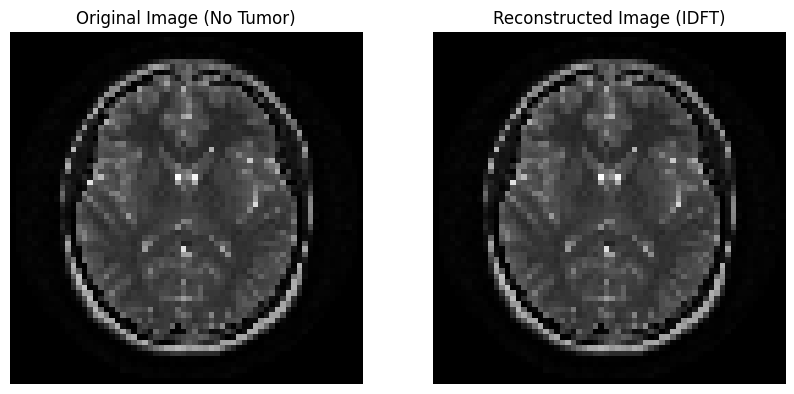


Q2: Spectrum Analysis (using DFT from Q1)
> Computing and displaying magnitude and power spectrum


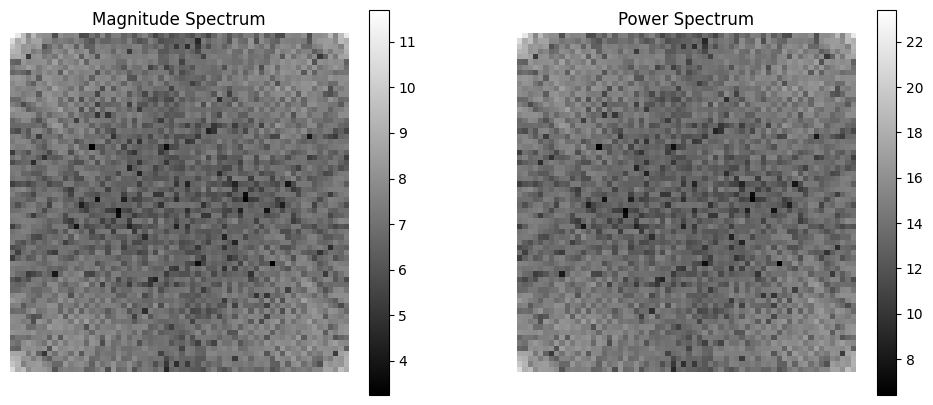


Q3: Low-Pass Filtering on the 'no' image
> Generating Filters
> Applying Filters and Reconstructing


>> Computing 2D IDFT:   0%|          | 0/16777216 [00:00<?, ?steps/s]

>> Computing 2D IDFT:   0%|          | 0/16777216 [00:00<?, ?steps/s]

>> Computing 2D IDFT:   0%|          | 0/16777216 [00:00<?, ?steps/s]

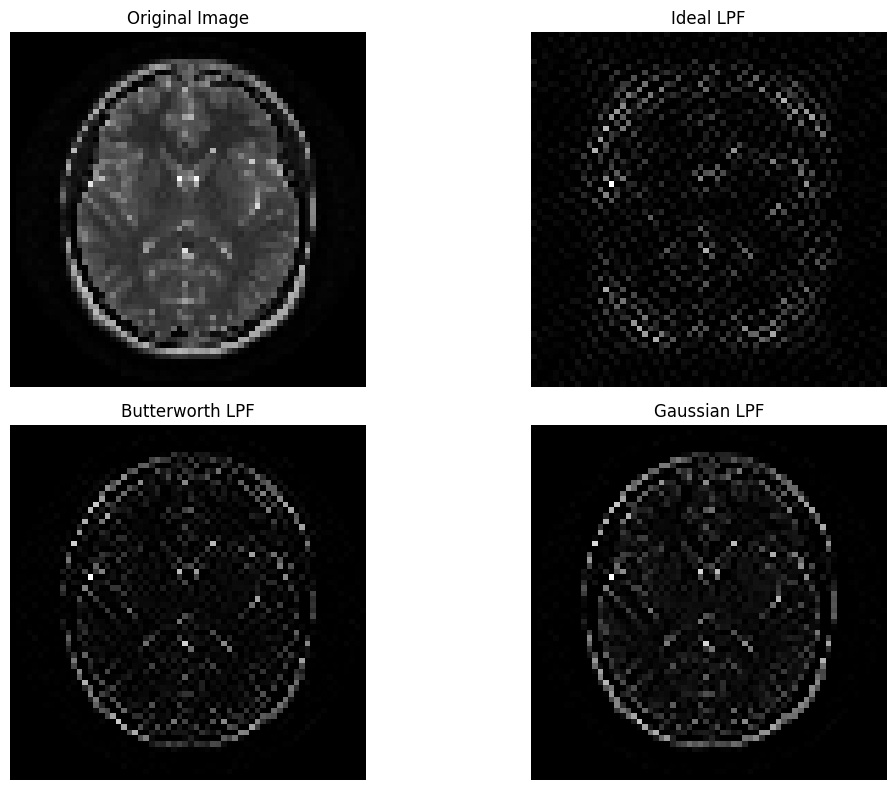


Q4: High-Frequency Emphasis Filtering on a 'yes' (tumor) image
> Loading tumor image from 'yes' folder (adjust path as needed)
> Computing DFT of the image


>> Computing 2D DFT:   0%|          | 0/16777216 [00:00<?, ?steps/s]


> Applying the high-frequency emphasis filter in frequency domain


>> Computing 2D IDFT:   0%|          | 0/16777216 [00:00<?, ?steps/s]

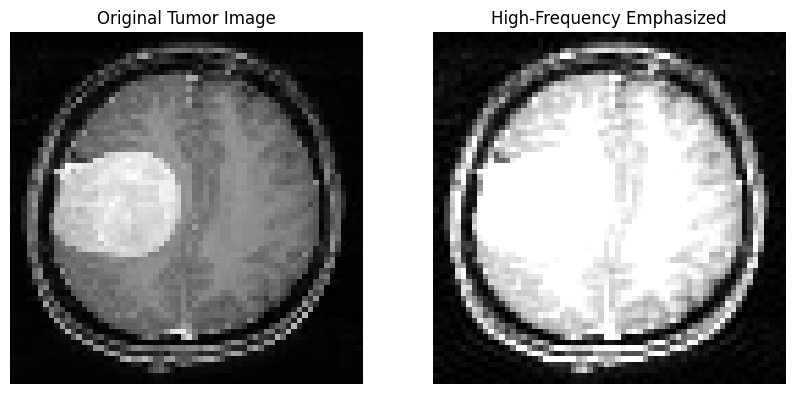


Q5: Homomorphic Filtering for contrast enhancement


>> Computing 2D DFT:   0%|          | 0/16777216 [00:00<?, ?steps/s]

>> Computing 2D IDFT:   0%|          | 0/16777216 [00:00<?, ?steps/s]

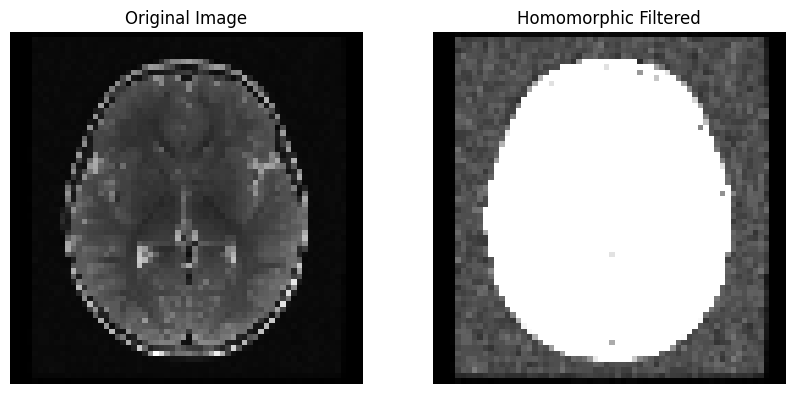


Q6: Performance Evaluation

Performance Evaluation for LPF (No Tumor Image):
> Computing performance metrics for LPF


>> Computing 2D DFT:   0%|          | 0/16777216 [00:00<?, ?steps/s]

>> Computing 2D DFT:   0%|          | 0/16777216 [00:00<?, ?steps/s]


> LPF Performance:
>> MSE: 783.062255859375
>> PSNR: 19.19284069689422
>> Total Power (Original): 35693142015.99997
>> Total Power (LPF): 14205464575.999989



>> Computing 2D DFT:   0%|          | 0/16777216 [00:00<?, ?steps/s]


> High-Frequency Emphasis Performance:
> MSE: 18535.888427734375
> PSNR: 5.450669542079768
> Total Power (HFE): 482270818303.9991

Q7: Ringing Artifacts Analysis & Reduction on synthetic image
> Generating synthetic image


>> Computing 2D DFT:   0%|          | 0/16777216 [00:00<?, ?steps/s]

>> Computing 2D IDFT:   0%|          | 0/16777216 [00:00<?, ?steps/s]

>> Computing 2D IDFT:   0%|          | 0/16777216 [00:00<?, ?steps/s]

>> Computing 2D IDFT:   0%|          | 0/16777216 [00:00<?, ?steps/s]

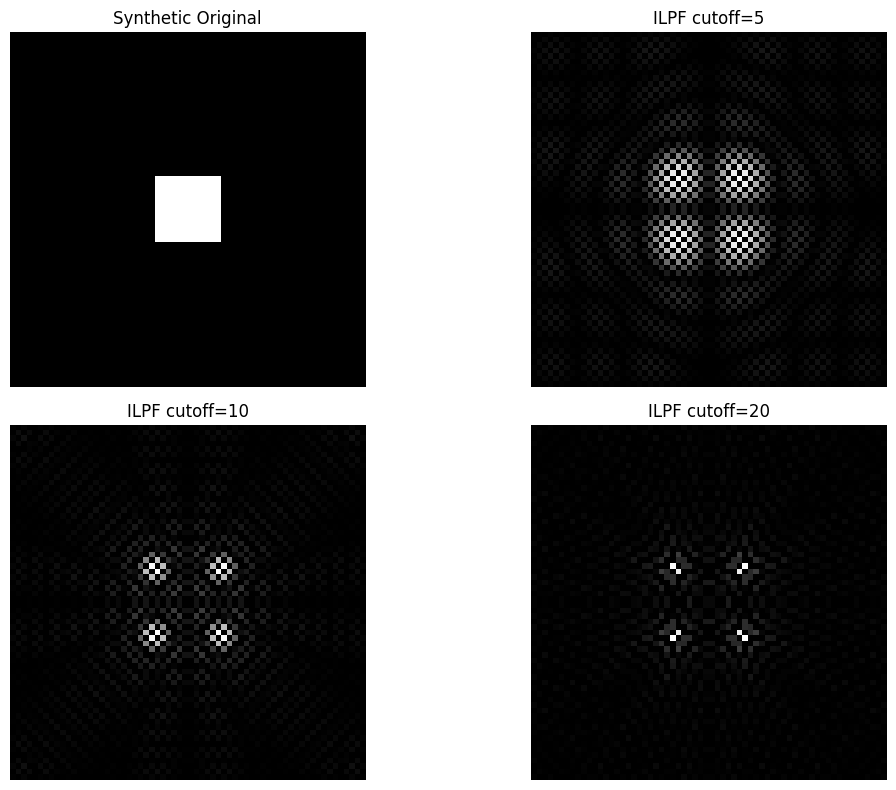

> Applying custom smooth filter to reduce ringing artifacts


>> Computing 2D IDFT:   0%|          | 0/16777216 [00:00<?, ?steps/s]

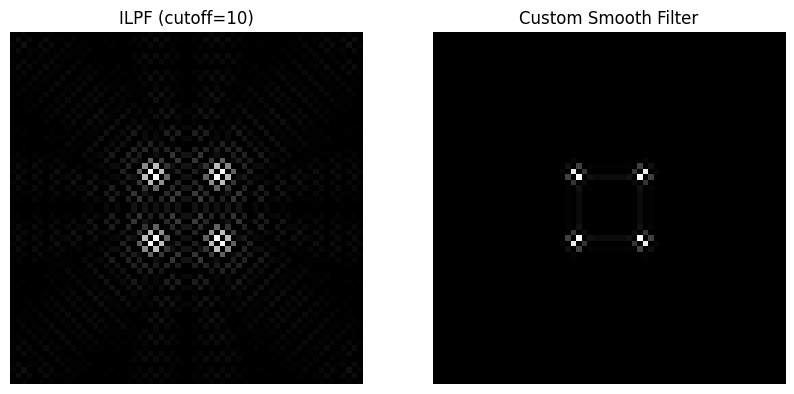

In [89]:
if __name__ == "__main__":
    print("Q1: DFT & IDFT reconstruction and error evaluation")
    img_no, F_no, img_recon_no = q1_dft_idft()

    print("\nQ2: Spectrum Analysis (using DFT from Q1)")
    q2_spectrum_analysis(F_no, img_no.shape)

    print("\nQ3: Low-Pass Filtering on the 'no' image")
    lpf_recons = q3_low_pass_filtering(img_no, F_no)
    # For performance evaluation, let’s choose one LPF reconstruction (e.g., Gaussian LPF)
    lpf_image = lpf_recons["Gaussian LPF"]

    print("\nQ4: High-Frequency Emphasis Filtering on a 'yes' (tumor) image")
    img_yes, img_hfe = q4_high_frequency_emphasis()

    print("\nQ5: Homomorphic Filtering for contrast enhancement")
    img_homo_original, img_homo = q5_homomorphic_filtering()

    print("\nQ6: Performance Evaluation")
    # We compare the original 'no' image with the low-pass filtered image
    print("\nPerformance Evaluation for LPF (No Tumor Image):")
    q6_performance_evaluation(img_no, lpf_image, img_hfe)  # Note: using img_hfe (from tumor image) for HFE metrics

    print("\nQ7: Ringing Artifacts Analysis & Reduction on synthetic image")
    q7_ringing_artifacts()